<img src='otus.png'>

# Лекция 22: "Нейронные сети, часть 1"

План лекции:

1. Вычислительные графы. Библиотека Pytorch и ее отличия от Tensorflow.
2. Пример: линейная регрессия.
3. Нейронные сети: базовые понятия.
4. Пример: логистическая регрессия, полносвязная нейронная сеть.
5. Метод обратного распространения ошибки.

Если у вас появился существенный для понимания вопрос, пишите "111" в чат.

In [3]:
%matplotlib inline

## 1. Pytorch

### Граф вычислений и дифференцирование

Рассмотрим функцию $$x^2 + xy + (x + y)^2$$

Ее можно представить в виде графа несколькими способами (как композицию простых функций):

<img src='graph.png'>

См. ноутбук "pytorch_tutorial.ipynb".

## 2. Линейная регрессия

### 2а. Подготовка данных

In [4]:
import torch
import matplotlib.pyplot as plt

true_slope, true_bias = 2., 1.
n_samples = 100

x = torch.rand(n_samples, 1)
y = true_slope * x + true_bias + 0.1 * torch.randn(n_samples, 1)

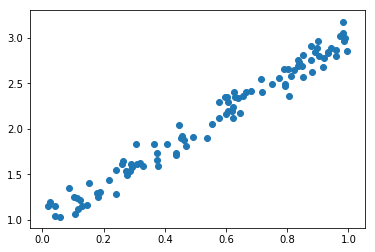

In [5]:
plt.scatter(x, y)
plt.show()

### 2б. Аналитическое решение

*Напоминание.*

В случае квадратичной функции потерь можно выписать простое аналитическое выражение для коэффициентов линейной регрессии:

$$\theta =  (X^T X)^{-1}X^T Y$$

Здесь $X$ это матрица признаков ($N \times d$), а $Y$ это вектор-столбец ($N \times 1$) наблюдений целевой переменной.

Последняя компонента $X$ равна 1 (просто соглашение), для того чтобы избавиться в формулах от "сдвига". Например, 
$$y=2x_1 + 4x_2+3$$
Можно записать двумя разными способами:
1. $y=\theta^T x = (2, 4, 3)\cdot(x_1, x_2, 1)$
2. $y=\theta^T x + b = (2, 4)\cdot(x_1, x_2) + 3$

Далее пользуемся первым способом.

In [6]:
ones = torch.ones(n_samples, 1)
x_ones = torch.cat((x, ones), dim=1)  # concatenated with ones
x_ones_t = torch.t(x_ones) # transposed

theta = torch.inverse(x_ones_t.mm(x_ones)).mm(x_ones_t).mm(y)

print('slope: {}, bias: {}'.format(*theta.numpy()))

slope: [2.0100884], bias: [0.99190784]


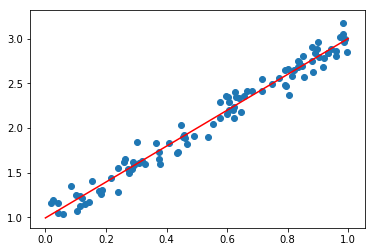

In [7]:
# trained model
line = torch.tensor([[0, 1.],[1., 1.]])
values = torch.mm(line, theta)
plt.plot(line[0].numpy(), values.numpy(), color='red')
plt.scatter(x, y)
plt.show()

### 2в. Решение с помощью оптимизации функции потерь

In [8]:
from torch.autograd import Variable

In [9]:
w = torch.randn(2, 1, requires_grad=True)           # параметры theta, инициализированные случайно
w

tensor([[0.4222],
        [0.0261]], requires_grad=True)

In [10]:
num_steps = 1000
learning_rate = 0.1
losses = []
for i in range(num_steps):
    y_pred = x_ones.mm(w)
    loss = (y - y_pred).pow(2).mean(dim=0)
    losses.append(float(loss.data))
    loss.backward()
    with torch.no_grad():
        w -= learning_rate * w.grad
        w.grad.zero_()

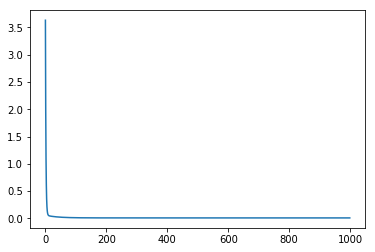

final loss: 0.010


In [11]:
plt.plot(losses)
plt.show()
print('final loss: {:.3f}'.format(losses[-1]))

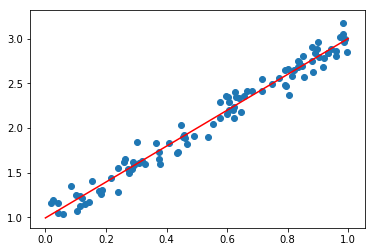

In [12]:
# trained model
line = torch.tensor([[0, 1.],[1., 1.]])
values = torch.mm(line, w)
plt.plot(line[0].numpy(), values.data.numpy(), color='red')
plt.scatter(x, y)
plt.show()

## 3. Нейронные сети: базовые определения

См. презентацию.

Полносвязная сеть ($A$ - входы, размер $N \times d$):


$$L_1 = f_1(W_1 A+b_1)$$
$$L_2 = f_2(W_2 L_1+b_2)$$
$$OUT = f_3(W_3 L_2+b_3)$$

## 4. Логистическая регрессия

### 4б. Подготовка данных

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from pandas.tools.plotting import table
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

np.random.seed(84)


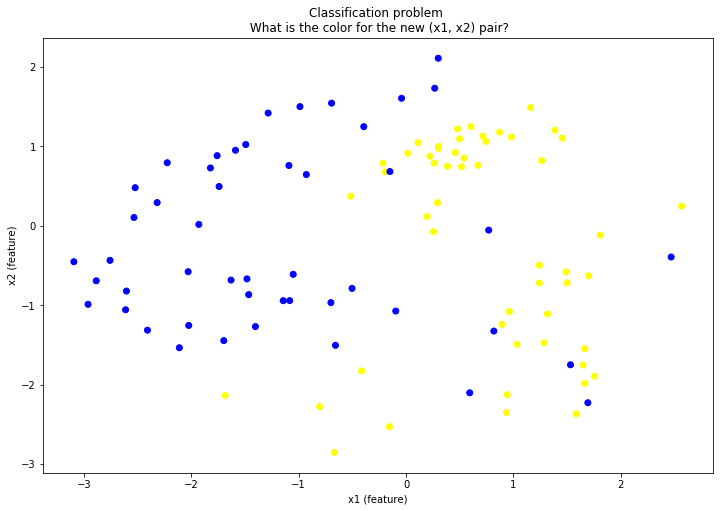

(130, 2) (130,)


In [14]:
X, y = datasets.make_classification(n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=12, n_samples=130)
x = np.c_[np.ones((X.shape[0], 1)), X]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=30, random_state=42)

colors = ['yellow' if y_i else 'blue' for y_i in y_train]
plt.scatter(x_train[:, 1], x_train[:, 2], c=colors)
plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.show()

print(X.shape, y.shape)

## 4б. Логистическая регрессия

Для линейной регрессии мы написали "наивный" алгоритм, сейчас время воспользоваться полезными абстракциями, который предлагает Pytorch:

* Модульность (nn)
* Оптимизаторы (optim)

Внимание: это упрощенная и наглядная версия, в реальности лучше рассчитывать логиты (logits) и по ним уже считать значение функции потерь. Численно это более устойчивый вариант.

In [15]:
import torch.nn as nn

learning_rate = 1e-2

In [16]:
def make_grid(x_min=-1, x_max=1, y_min=-1, y_max=1, step_x=0.1, step_y=0.1):
    x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, step_x), np.arange(y_min, y_max, step_y))
    pos = np.empty(x_grid.shape + (2,))
    pos[:, :, 0] = x_grid
    pos[:, :, 1] = y_grid
    pos_lin = pos.reshape(pos.shape[0] * pos.shape[1], 2)
    return pos_lin, x_grid, y_grid

In [17]:
class LogisticRegression(nn.Module):
    def __init__(self, inp_size=3, out_size=1):
        """
        Определим одно линейное преобразование при инициализации.
        """
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(inp_size, out_size)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        """
        Метод "forward" принимает на вход тензор с данными и возвращает результат расчета.
        """
        out = self.sigm(self.linear(x))
        return out

In [18]:
model = LogisticRegression()
criterion = nn.BCELoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

[]

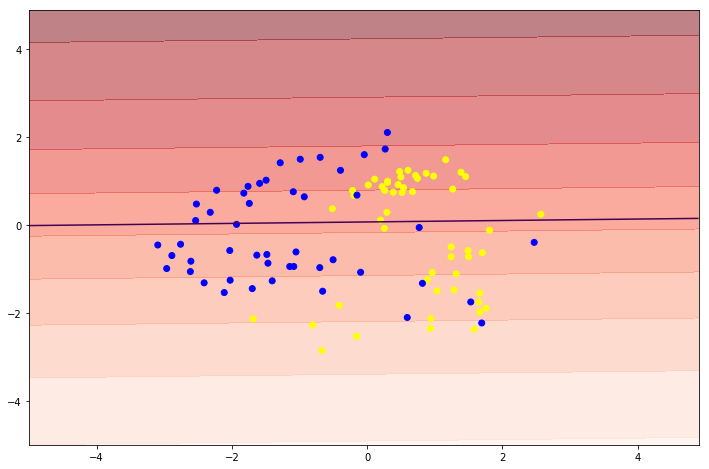

In [19]:
# visualize decision boundary -- before training
grid, xm, ym = make_grid(-5, 5, -5, 5)
out = model(torch.cat((torch.ones(grid.shape[0], 1), torch.tensor(grid.astype(np.float32))), dim=1))
plt.contourf(xm, ym, out.data.numpy().reshape(xm.shape), 10, cmap='Reds', origin='lower', alpha=0.5)
plt.contour(xm, ym, out.data.numpy().reshape(xm.shape), levels=[0.5])
plt.scatter(x_train[:, 1], x_train[:, 2], c=colors)
plt.plot()

In [20]:
x = torch.tensor(x_train.astype(np.float32))
y = torch.tensor(y_train.reshape((-1, 1)).astype(np.float32))
losses = []
for t in range(1000):
    # расчет предсказания модели
    y_pred = model(torch.tensor(x))

    # расчет функции потерь
    loss = criterion(y_pred, y)
    print('step: {}; training loss: {:.3f}'.format(t, loss.item()))
    losses.append(loss.item())

    # обнулить градиенты, рассчитать новые градиенты, обновить веса
    opt.zero_grad()
    loss.backward()
    opt.step()

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


step: 0; training loss: 0.719
step: 1; training loss: 0.716
step: 2; training loss: 0.714
step: 3; training loss: 0.712
step: 4; training loss: 0.709
step: 5; training loss: 0.707
step: 6; training loss: 0.705
step: 7; training loss: 0.703
step: 8; training loss: 0.701
step: 9; training loss: 0.698
step: 10; training loss: 0.696
step: 11; training loss: 0.694
step: 12; training loss: 0.692
step: 13; training loss: 0.690
step: 14; training loss: 0.688
step: 15; training loss: 0.686
step: 16; training loss: 0.684
step: 17; training loss: 0.682
step: 18; training loss: 0.680
step: 19; training loss: 0.678
step: 20; training loss: 0.676
step: 21; training loss: 0.674
step: 22; training loss: 0.672
step: 23; training loss: 0.670
step: 24; training loss: 0.668
step: 25; training loss: 0.666
step: 26; training loss: 0.664
step: 27; training loss: 0.662
step: 28; training loss: 0.661
step: 29; training loss: 0.659
step: 30; training loss: 0.657
step: 31; training loss: 0.655
step: 32; training

step: 405; training loss: 0.452
step: 406; training loss: 0.452
step: 407; training loss: 0.452
step: 408; training loss: 0.452
step: 409; training loss: 0.451
step: 410; training loss: 0.451
step: 411; training loss: 0.451
step: 412; training loss: 0.451
step: 413; training loss: 0.451
step: 414; training loss: 0.451
step: 415; training loss: 0.451
step: 416; training loss: 0.451
step: 417; training loss: 0.451
step: 418; training loss: 0.450
step: 419; training loss: 0.450
step: 420; training loss: 0.450
step: 421; training loss: 0.450
step: 422; training loss: 0.450
step: 423; training loss: 0.450
step: 424; training loss: 0.450
step: 425; training loss: 0.450
step: 426; training loss: 0.450
step: 427; training loss: 0.449
step: 428; training loss: 0.449
step: 429; training loss: 0.449
step: 430; training loss: 0.449
step: 431; training loss: 0.449
step: 432; training loss: 0.449
step: 433; training loss: 0.449
step: 434; training loss: 0.449
step: 435; training loss: 0.449
step: 43

step: 822; training loss: 0.430
step: 823; training loss: 0.430
step: 824; training loss: 0.430
step: 825; training loss: 0.430
step: 826; training loss: 0.430
step: 827; training loss: 0.430
step: 828; training loss: 0.430
step: 829; training loss: 0.430
step: 830; training loss: 0.430
step: 831; training loss: 0.430
step: 832; training loss: 0.430
step: 833; training loss: 0.430
step: 834; training loss: 0.430
step: 835; training loss: 0.430
step: 836; training loss: 0.430
step: 837; training loss: 0.430
step: 838; training loss: 0.430
step: 839; training loss: 0.430
step: 840; training loss: 0.429
step: 841; training loss: 0.429
step: 842; training loss: 0.429
step: 843; training loss: 0.429
step: 844; training loss: 0.429
step: 845; training loss: 0.429
step: 846; training loss: 0.429
step: 847; training loss: 0.429
step: 848; training loss: 0.429
step: 849; training loss: 0.429
step: 850; training loss: 0.429
step: 851; training loss: 0.429
step: 852; training loss: 0.429
step: 85

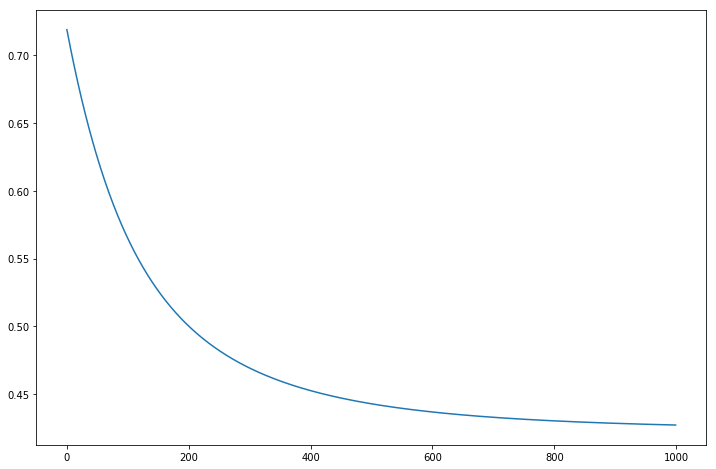

final loss: 0.427


In [21]:
plt.plot(losses)
plt.show()
print('final loss: {:.3f}'.format(losses[-1]))

[]

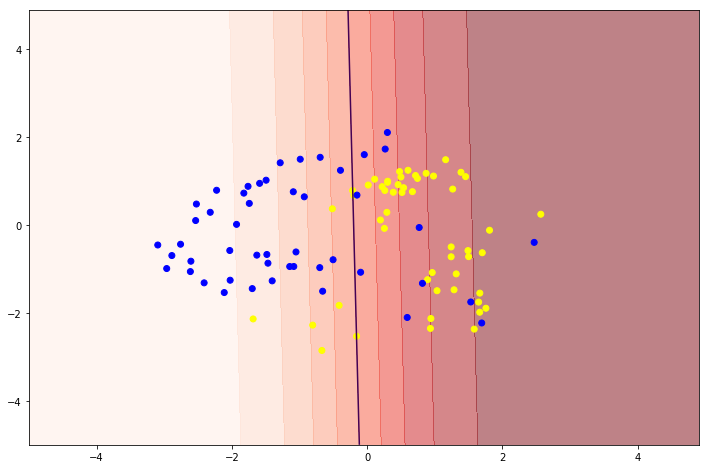

In [22]:
# visualize decision boundary -- after training
grid, xm, ym = make_grid(-5, 5, -5, 5)
out = model(torch.cat((torch.ones(grid.shape[0], 1), torch.tensor(grid.astype(np.float32))), dim=1))
plt.contourf(xm, ym, out.data.numpy().reshape(xm.shape), 10, cmap='Reds', origin='lower', alpha=0.5)
plt.contour(xm, ym, out.data.numpy().reshape(xm.shape), levels=[0.5])
plt.scatter(x_train[:, 1], x_train[:, 2], c=colors)
plt.plot()

## 4в. Полносвязная НС

Все абсолютно то же самое. Меняем только модель.

<img src='https://camo.githubusercontent.com/269f47b8185a2ca349ead57db511250553fd918b/687474703a2f2f63733233316e2e6769746875622e696f2f6173736574732f6e6e312f6e657572616c5f6e6574322e6a706567'>

In [26]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

In [27]:
criterion = nn.BCELoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

[]

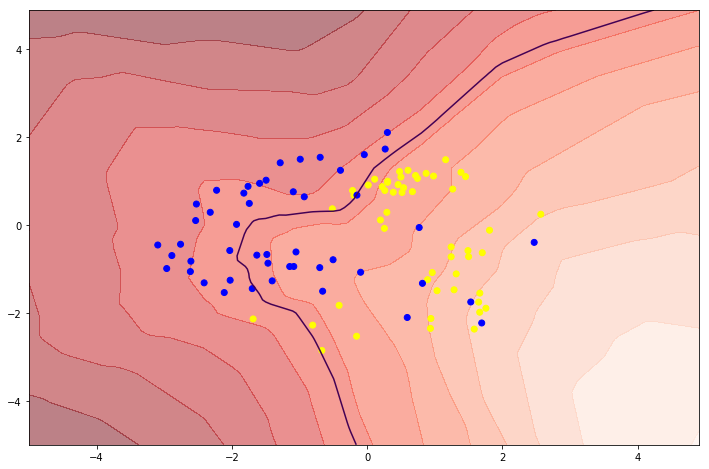

In [28]:
# visualize decision boundary -- before training
grid, xm, ym = make_grid(-5, 5, -5, 5)
out = model(torch.cat((torch.ones(grid.shape[0], 1), torch.tensor(grid.astype(np.float32))), dim=1))
plt.contourf(xm, ym, out.data.numpy().reshape(xm.shape), 10, cmap='Reds', origin='lower', alpha=0.5)
plt.contour(xm, ym, out.data.numpy().reshape(xm.shape), levels=[0.5])
plt.scatter(x_train[:, 1], x_train[:, 2], c=colors)
plt.plot()

In [29]:
x = torch.tensor(x_train.astype(np.float32))
y = torch.tensor(y_train.reshape((-1, 1)).astype(np.float32))
losses = []
for t in range(1000):
    # расчет предсказания модели
    y_pred = model(torch.tensor(x))

    # расчет функции потерь
    loss = criterion(y_pred, y)
    print('step: {}; training loss: {:.3f}'.format(t, loss.item()))
    losses.append(loss.item())

    # обнулить градиенты, рассчитать новые градиенты, обновить веса
    opt.zero_grad()
    loss.backward()
    opt.step()

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


step: 0; training loss: 0.715
step: 1; training loss: 0.714
step: 2; training loss: 0.713
step: 3; training loss: 0.712
step: 4; training loss: 0.711
step: 5; training loss: 0.710
step: 6; training loss: 0.709
step: 7; training loss: 0.708
step: 8; training loss: 0.707
step: 9; training loss: 0.706
step: 10; training loss: 0.705
step: 11; training loss: 0.704
step: 12; training loss: 0.703
step: 13; training loss: 0.702
step: 14; training loss: 0.701
step: 15; training loss: 0.700
step: 16; training loss: 0.699
step: 17; training loss: 0.698
step: 18; training loss: 0.697
step: 19; training loss: 0.696
step: 20; training loss: 0.695
step: 21; training loss: 0.694
step: 22; training loss: 0.693
step: 23; training loss: 0.692
step: 24; training loss: 0.691
step: 25; training loss: 0.690
step: 26; training loss: 0.690
step: 27; training loss: 0.689
step: 28; training loss: 0.688
step: 29; training loss: 0.687
step: 30; training loss: 0.686
step: 31; training loss: 0.685
step: 32; training

step: 277; training loss: 0.497
step: 278; training loss: 0.496
step: 279; training loss: 0.495
step: 280; training loss: 0.495
step: 281; training loss: 0.494
step: 282; training loss: 0.493
step: 283; training loss: 0.493
step: 284; training loss: 0.492
step: 285; training loss: 0.492
step: 286; training loss: 0.491
step: 287; training loss: 0.490
step: 288; training loss: 0.490
step: 289; training loss: 0.489
step: 290; training loss: 0.489
step: 291; training loss: 0.488
step: 292; training loss: 0.487
step: 293; training loss: 0.487
step: 294; training loss: 0.486
step: 295; training loss: 0.486
step: 296; training loss: 0.485
step: 297; training loss: 0.485
step: 298; training loss: 0.484
step: 299; training loss: 0.483
step: 300; training loss: 0.483
step: 301; training loss: 0.482
step: 302; training loss: 0.482
step: 303; training loss: 0.481
step: 304; training loss: 0.481
step: 305; training loss: 0.480
step: 306; training loss: 0.479
step: 307; training loss: 0.479
step: 30

step: 568; training loss: 0.402
step: 569; training loss: 0.402
step: 570; training loss: 0.402
step: 571; training loss: 0.402
step: 572; training loss: 0.402
step: 573; training loss: 0.402
step: 574; training loss: 0.402
step: 575; training loss: 0.402
step: 576; training loss: 0.401
step: 577; training loss: 0.401
step: 578; training loss: 0.401
step: 579; training loss: 0.401
step: 580; training loss: 0.401
step: 581; training loss: 0.401
step: 582; training loss: 0.401
step: 583; training loss: 0.401
step: 584; training loss: 0.401
step: 585; training loss: 0.400
step: 586; training loss: 0.400
step: 587; training loss: 0.400
step: 588; training loss: 0.400
step: 589; training loss: 0.400
step: 590; training loss: 0.400
step: 591; training loss: 0.400
step: 592; training loss: 0.400
step: 593; training loss: 0.399
step: 594; training loss: 0.399
step: 595; training loss: 0.399
step: 596; training loss: 0.399
step: 597; training loss: 0.399
step: 598; training loss: 0.399
step: 59

step: 833; training loss: 0.380
step: 834; training loss: 0.380
step: 835; training loss: 0.380
step: 836; training loss: 0.379
step: 837; training loss: 0.379
step: 838; training loss: 0.379
step: 839; training loss: 0.379
step: 840; training loss: 0.379
step: 841; training loss: 0.379
step: 842; training loss: 0.379
step: 843; training loss: 0.379
step: 844; training loss: 0.379
step: 845; training loss: 0.379
step: 846; training loss: 0.379
step: 847; training loss: 0.379
step: 848; training loss: 0.378
step: 849; training loss: 0.378
step: 850; training loss: 0.378
step: 851; training loss: 0.378
step: 852; training loss: 0.378
step: 853; training loss: 0.378
step: 854; training loss: 0.378
step: 855; training loss: 0.378
step: 856; training loss: 0.378
step: 857; training loss: 0.378
step: 858; training loss: 0.378
step: 859; training loss: 0.377
step: 860; training loss: 0.377
step: 861; training loss: 0.377
step: 862; training loss: 0.377
step: 863; training loss: 0.377
step: 86

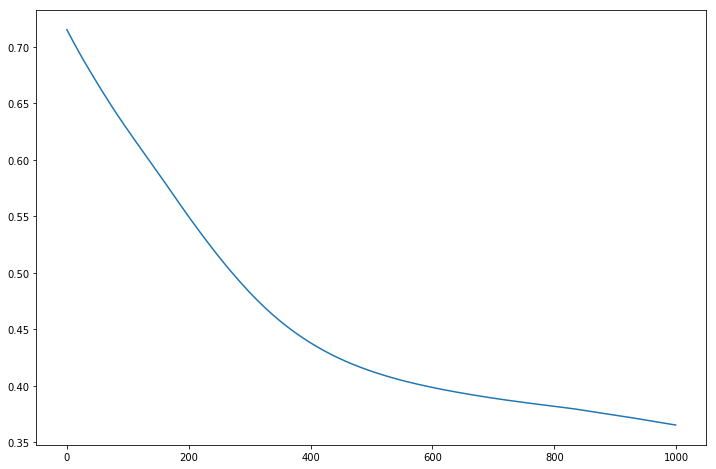

final loss: 0.365


In [30]:
plt.plot(losses)
plt.show()
print('final loss: {:.3f}'.format(losses[-1]))

[]

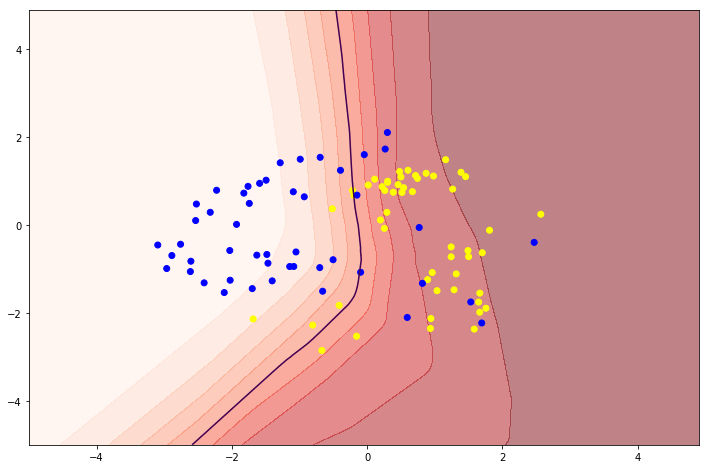

In [31]:
# visualize decision boundary -- after training
grid, xm, ym = make_grid(-5, 5, -5, 5)
out = model(torch.cat((torch.ones(grid.shape[0], 1), torch.tensor(grid.astype(np.float32))), dim=1))
plt.contourf(xm, ym, out.data.numpy().reshape(xm.shape), 10, cmap='Reds', origin='lower', alpha=0.5)
plt.contour(xm, ym, out.data.numpy().reshape(xm.shape), levels=[0.5])
plt.scatter(x_train[:, 1], x_train[:, 2], c=colors)
plt.plot()

## Обучение нейронной сети, алгоритм обратного распространения ошибки

### Граф вычислений и дифференцирование

Рассмотрим функцию $$x^2 + xy + (x + y)^2$$

Ее можно представить в виде графа несколькими способами (как композицию простых функций):

<img src='graph.png'>

Будем рассматривать граф слева как исходный для вычисления функции.

Дифференцирование. Пользуемся правилом дифференцирования сложной функции.

$$(f\circ g)\prime(x) = (f(g(x)))\prime = f\prime(g(x))g\prime(x)$$

<img src='g1.png'>

Алгоритм: ищем все пути в графе от $f$ к $x$ и суммируем произведения производных для каждого пути. 

Разбор примера см в [1]


## Виды оптимизаторов

## Функции активации

<img src='act.png'>

Логистический сигмоид

$$ \frac{1}{1 + e^{-x}}$$

Гиперболический тангенс tanh

$$\frac{e^x-e^{-x}}{e^x+e^{-x}}$$

Ступенька (функция Хевисайда)

$$\begin{cases}
    0, & x < 0\\
    1, & x \geq 0.
  \end{cases}$$
  
ReLU
$$\begin{cases}
    0, & x < 0\\
    x, & x \geq 0.
  \end{cases}$$


## Проблема xor


![alt text](http://web.science.mq.edu.au/~cassidy/comp449/html/xor.gif)

Здесь можно посмотреть как влияют параметры нейронных сетей на итоговое решение:
https://goo.gl/LvPGqU

### Сравнение фреймворков

* Tensorflow + Keras
* Pytorch

====

* mxnet, Caffe, CNTK, Theano

## Литература

1. Николенко, Кадурин, Архангельская. Глубокое обучение. Погружение в мир нейронных сетей.
2. Aurélien Géron Hands-on Machine Learning with Scikit-Learn and TensorFlow
3. Гудфеллоу, Бенджио, Курвилль. Глубокое обучение